In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2010-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [6]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]
T = [1, 5, 10, 21, 42, 63]

In [7]:
percentiles

[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]

In [8]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv] # select OHLCV columns from 2010 until 2017
              .rename(columns=lambda x: x.replace('adj_', '')) # simplify column names
              .swaplevel()
              .sort_index())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])

In [9]:
prices.volume /= 1e3 # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

In [11]:
prices

open      close        low       high    volume
symbol date                                                            
A      2010-01-04  21.415535  21.354133  21.239108  21.579273  2729.300
       2010-01-05  21.292732  21.122172  20.985724  21.299554  2994.300
       2010-01-06  21.047125  21.047125  20.985724  21.149461  2320.300
       2010-01-07  20.999368  21.019836  20.808341  21.026658  2214.000
       2010-01-08  20.903855  21.013013  20.740117  21.047125  2670.900
...                      ...        ...        ...        ...       ...
ZUMZ   2017-12-22  21.550000  21.450000  21.300000  21.700000   209.585
       2017-12-26  21.450000  21.850000  21.450000  22.200000   213.951
       2017-12-27  21.800000  21.150000  20.950000  22.250000   227.325
       2017-12-28  21.200000  21.200000  21.050000  21.450000   162.070
       2017-12-29  21.250000  20.825000  20.800000  21.450000   222.040

[5698754 rows x 5 columns]

In [12]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

In [16]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [19]:
shared = prices.index.get_level_values('symbol').unique().intersection(metadata.index)
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [20]:
universe = metadata.marketcap.nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [21]:
metadata.sector.value_counts()

consumer_services        187
finance                  168
technology               116
health_care              103
capital_goods             94
basic_industries          67
public_utilities          66
consumer_non-durables     61
energy                    51
consumer_durables         36
miscellaneous             28
transportation            23
Name: sector, dtype: int64

In [22]:

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2004775 non-null  float64
 1   close   2004775 non-null  float64
 2   low     2004775 non-null  float64
 3   high    2004775 non-null  float64
 4   volume  2004775 non-null  float64
dtypes: float64(5)
memory usage: 84.9+ MB


In [23]:

metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, AAPL to NTCT
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  1000 non-null   float64
 1   sector     1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


In [24]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

In [25]:
dollar_vol_ma = (prices
                .dollar_vol
                .unstack('symbol')
                .rolling(window=21, min_periods=1)
                .mean())

In [36]:
prices['dollar_vol_rank'] = dollar_vol_ma.rank(axis=1, ascending=False).stack('symbol').swaplevel()

In [37]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2004775 non-null  float64
 1   close            2004775 non-null  float64
 2   low              2004775 non-null  float64
 3   high             2004775 non-null  float64
 4   volume           2004775 non-null  float64
 5   dollar_vol       2004775 non-null  float64
 6   dollar_vol_rank  2004775 non-null  float64
dtypes: float64(7)
memory usage: 115.5+ MB


In [41]:
#Add some basic factors
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI)

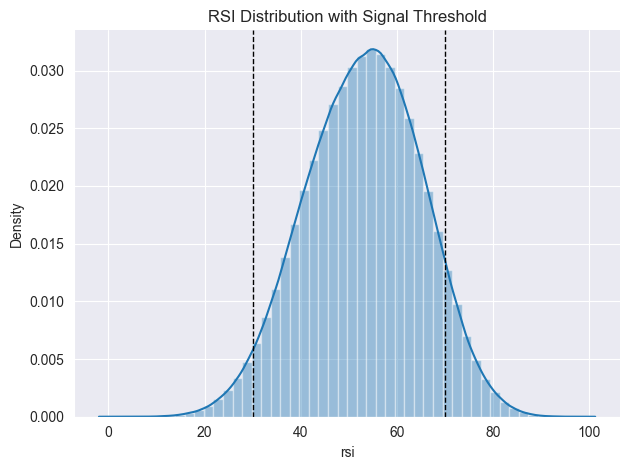

In [42]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

In [43]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [45]:
prices = prices.join(prices.groupby(level='symbol').close.apply(compute_bb))

In [46]:
prices

open      close        low       high      volume  \
symbol date                                                                 
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.400   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.200   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.000   
       2010-01-07  27.212826  27.062465  26.865839  27.244955  119282.800   
       2010-01-08  27.026481  27.242385  26.867124  27.244955  111902.700   
...                      ...        ...        ...        ...         ...   
NTCT   2017-12-22  31.400000  31.550000  31.050000  31.725000     568.152   
       2017-12-26  31.400000  31.050000  30.800000  31.550000     404.679   
       2017-12-27  31.100000  31.050000  30.800000  31.300000     278.693   
       2017-12-28  31.050000  30.650000  30.475000  31.050000     264.128   
       2017-12-29  30.700000  30.450000  30.250000  30.800000     393.595   

                    dollar_vol  dollar_vol_rank        rsi    bb_high  \
symbol date                                                             
AAPL   2010-01-04  3394.794352              1.0        NaN        NaN   
       2010-01-05  4145.742393              1.0        NaN        NaN   
       2010-01-06  3742.621292              1.0        NaN        NaN   
       2010-01-07  3228.086599              1.0        NaN        NaN   
       2010-01-08  3048.496380              2.0        NaN        NaN   
...                        ...              ...        ...        ...   
NTCT   2017-12-22    17.925196            666.0  61.741125  32.055057   
       2017-12-26    12.565283            668.0  55.773339  32.088266   
       2017-12-27     8.653418            675.0  55.773339  32.047123   
       2017-12-28     8.095523            687.0  51.183203  31.908980   
       2017-12-29    11.984968            701.0  49.011255  31.854334   

                      bb_low  
symbol date                   
AAPL   2010-01-04        NaN  
       2010-01-05        NaN  
       2010-01-06        NaN  
       2010-01-07        NaN  
       2010-01-08        NaN  
...                      ...  
NTCT   2017-12-22  28.984943  
       2017-12-26  28.986734  
       2017-12-27  28.997877  
       2017-12-28  29.036020  
       2017-12-29  29.030666  

[2004775 rows x 10 columns]

In [47]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

In [48]:
prices

open      close        low       high      volume  \
symbol date                                                                 
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.400   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.200   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.000   
       2010-01-07  27.212826  27.062465  26.865839  27.244955  119282.800   
       2010-01-08  27.026481  27.242385  26.867124  27.244955  111902.700   
...                      ...        ...        ...        ...         ...   
NTCT   2017-12-22  31.400000  31.550000  31.050000  31.725000     568.152   
       2017-12-26  31.400000  31.050000  30.800000  31.550000     404.679   
       2017-12-27  31.100000  31.050000  30.800000  31.300000     278.693   
       2017-12-28  31.050000  30.650000  30.475000  31.050000     264.128   
       2017-12-29  30.700000  30.450000  30.250000  30.800000     393.595   

                    dollar_vol  dollar_vol_rank        rsi   bb_high    bb_low  
symbol date                                                                     
AAPL   2010-01-04  3394.794352              1.0        NaN       NaN       NaN  
       2010-01-05  4145.742393              1.0        NaN       NaN       NaN  
       2010-01-06  3742.621292              1.0        NaN       NaN       NaN  
       2010-01-07  3228.086599              1.0        NaN       NaN       NaN  
       2010-01-08  3048.496380              2.0        NaN       NaN       NaN  
...                        ...              ...        ...       ...       ...  
NTCT   2017-12-22    17.925196            666.0  61.741125  0.015633  0.078165  
       2017-12-26    12.565283            668.0  55.773339  0.031844  0.064335  
       2017-12-27     8.653418            675.0  55.773339  0.030640  0.063999  
       2017-12-28     8.095523            687.0  51.183203  0.038697  0.051319  
       2017-12-29    11.984968            701.0  49.011255  0.043142  0.045558  

[2004775 rows x 10 columns]

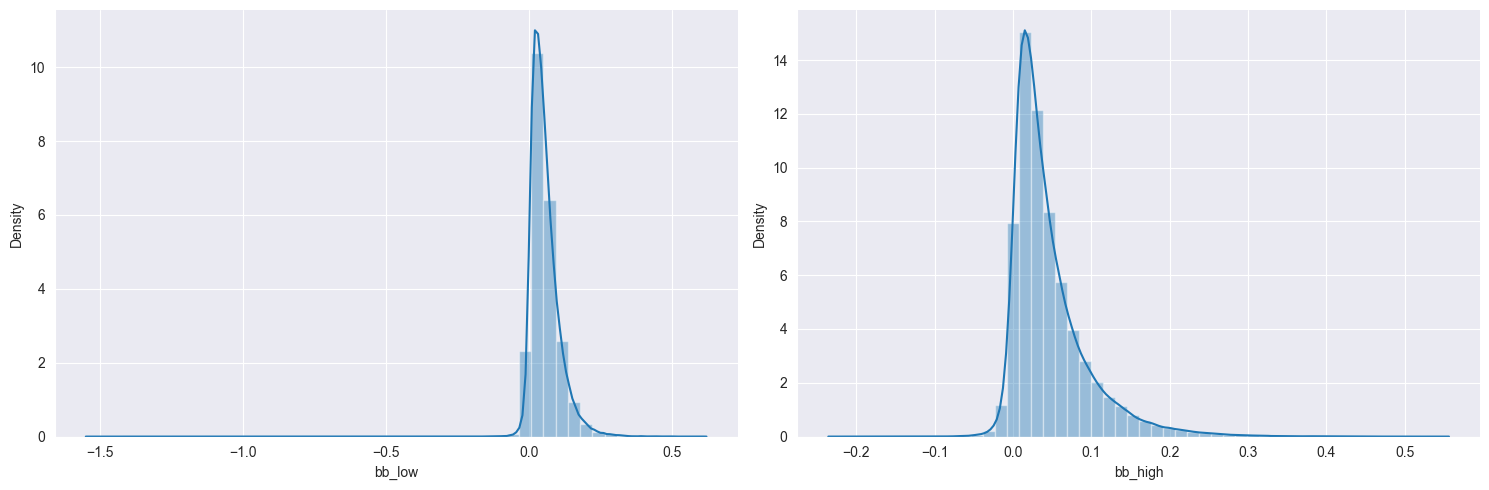

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

In [50]:
prices['natr'] = prices.groupby(level='symbol', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close))

In [56]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [57]:
prices['atr'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

In [58]:
prices['PPO'] = prices.groupby(level='symbol').close.apply(talib.PPO)

In [59]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [60]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

In [61]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

In [63]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

In [67]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                            .groupby(level='date')
                            .apply(lambda x: pd.qcut(x,
                                                     q=10,
                                                     labels=False,
                                                     duplicates='drop')))

In [68]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x, 
                                                               q=5, 
                                                               labels=False, 
                                                               duplicates='drop')))

In [69]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

In [70]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,2.003775e+06,1.999775e+06,1.994775e+06,1.983775e+06,1.962775e+06,1.941775e+06
mean,7.519751e-04,3.726962e-03,7.353932e-03,1.555927e-02,3.113691e-02,4.619119e-02
std,2.166262e-02,4.791746e-02,6.579895e-02,9.467552e-02,1.325751e-01,1.618423e-01
min,-8.757416e-01,-8.768476e-01,-8.778415e-01,-8.802285e-01,-8.867366e-01,-8.863481e-01
25%,-8.088407e-03,-1.721664e-02,-2.291896e-02,-3.045918e-02,-3.531712e-02,-3.696833e-02
50%,6.561680e-04,3.702235e-03,7.173181e-03,1.503253e-02,2.899023e-02,4.217809e-02
75%,9.509191e-03,2.440601e-02,3.707177e-02,5.927618e-02,9.305628e-02,1.219666e-01
max,1.216425e+01,1.252657e+01,1.252657e+01,1.252657e+01,1.181643e+01,1.166968e+01


In [71]:
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()

In [72]:
prices = prices.drop(outliers, level='symbol')

In [73]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

In [74]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1994931 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 39 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1994931 non-null  float64
 1   close            1994931 non-null  float64
 2   low              1994931 non-null  float64
 3   high             1994931 non-null  float64
 4   volume           1994931 non-null  float64
 5   dollar_vol       1994931 non-null  float64
 6   dollar_vol_rank  1994931 non-null  float64
 7   rsi              1981001 non-null  float64
 8   bb_high          1976026 non-null  float64
 9   bb_low           1976022 non-null  float64
 10  natr             1981001 non-null  float64
 11  atr              1981001 non-null  float64
 12  PPO              1970056 non-null  float64
 13  MACD             1962096 non-null  float64
 14  sector           1994931 non-null  int

In [75]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data.h5', 'model_data')